# =============================================
# KLASIFIKASI GAMBAR KUDA VS DEER DENGAN CNN
# =============================================

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


Konfigurasi dasar

In [2]:
DATA_DIR = "Dataset/DEMO"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42

# === 1. Eksplorasi Dataset ===

Cek jumlah data di masing-masing kelas

In [3]:
def count_images(folder):
    counts = {}
    total = 0
    for cls in os.listdir(folder):
        path = os.path.join(folder, cls)
        if os.path.isdir(path):
            n = len([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[cls] = n
            total += n
    return counts, total

train_counts, train_total = count_images(TRAIN_DIR)
test_counts, test_total = count_images(TEST_DIR)

print("=== Jumlah Data ===")
print("Train:", train_counts, "| Total:", train_total)
print("Test :", test_counts, "| Total:", test_total)
print("====================================\n")


=== Jumlah Data ===
Train: {'deer': 500, 'horse': 500} | Total: 1000
Test : {'deer': 250, 'horse': 250} | Total: 500



Visualisasi 5 contoh gambar dari masing-masing kelas

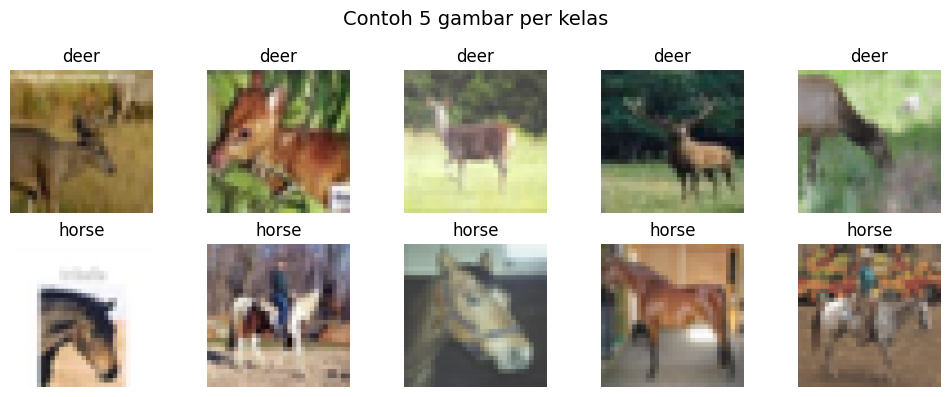

In [4]:
def show_examples(folder, classes=None, n_per_class=5):
    if classes is None:
        classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    plt.figure(figsize=(n_per_class * 2, len(classes) * 2))
    idx = 1
    for cls in classes:
        files = os.listdir(os.path.join(folder, cls))
        random.shuffle(files)
        for f in files[:n_per_class]:
            img_path = os.path.join(folder, cls, f)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
            idx += 1
    plt.suptitle("Contoh 5 gambar per kelas", fontsize=14)
    plt.tight_layout()
    plt.show()

show_examples(TRAIN_DIR, n_per_class=5)


# === 2. Preprocessing Data ===

Preprocessing

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Found 500 files belonging to 2 classes.


Normalisasi

In [12]:
normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# === 3. Membangun Model CNN ===

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SIZE + (3,)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])


# === 4. Training Model ===

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.8338 - loss: 0.3639 - val_accuracy: 0.7000 - val_loss: 0.5082
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.8750 - loss: 0.3269 - val_accuracy: 0.7350 - val_loss: 0.5283
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.8700 - loss: 0.2974 - val_accuracy: 0.7050 - val_loss: 0.5205
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8662 - loss: 0.3173 - val_accuracy: 0.6850 - val_loss: 0.5569
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.8975 - loss: 0.2743 - val_accuracy: 0.7150 - val_loss: 0.5594
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.8800 - loss: 0.2847 - val_accuracy: 0.7450 - val_loss: 0.5110
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.9025 - loss: 0.2509 - val_accuracy: 0.7350 - val_loss: 0.5408
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.8838 - loss: 0.2710 - val_accuracy: 0.

# === 5. Evaluasi Model ===

Uji model menggunakan data test

In [16]:
y_true, y_pred = [], []
for x, y in test_ds:
    preds = model.predict(x).ravel()
    y_pred.extend((preds >= 0.5).astype(int))
    y_true.extend(y.numpy().astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Hitung metrik seperti accuracy, precision, recall, dan F1-score

In [22]:
print("\n=== Evaluasi pada Data Test ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1-score :", f1_score(y_true, y_pred))
print("\n", classification_report(y_true, y_pred, target_names=['deer', 'horse']))


=== Evaluasi pada Data Test ===
Accuracy : 0.796
Precision: 0.8057851239669421
Recall   : 0.78
F1-score : 0.7926829268292683

               precision    recall  f1-score   support

        deer       0.79      0.81      0.80       250
       horse       0.81      0.78      0.79       250

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



# === 6. Visualisasi Hasil ===

accuracy untuk data train dan valid

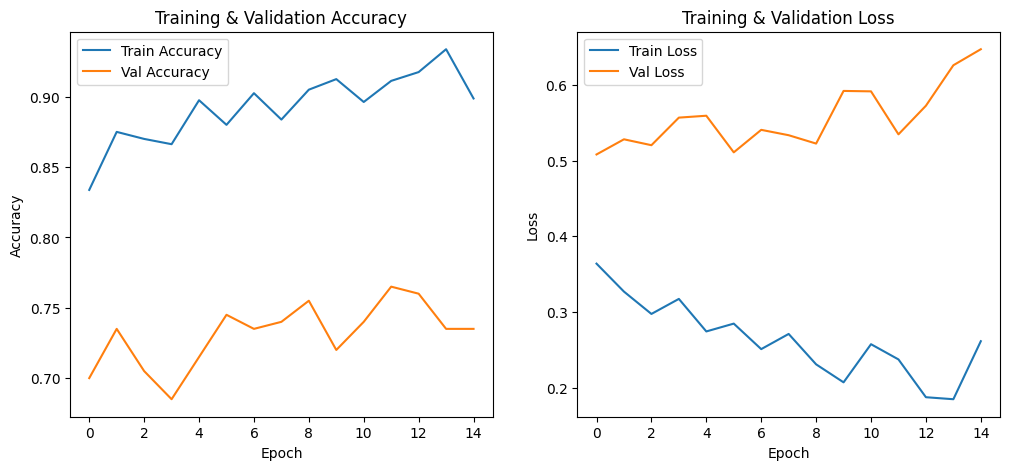

In [23]:
import matplotlib.pyplot as plt

# Grafik Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


5 gambar dari data test beserta prediksi model dan label aslinya

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


C:\Users\Faliq\AppData\Local\Temp\ipykernel_17996\2605396637.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(y_batch[i].numpy())


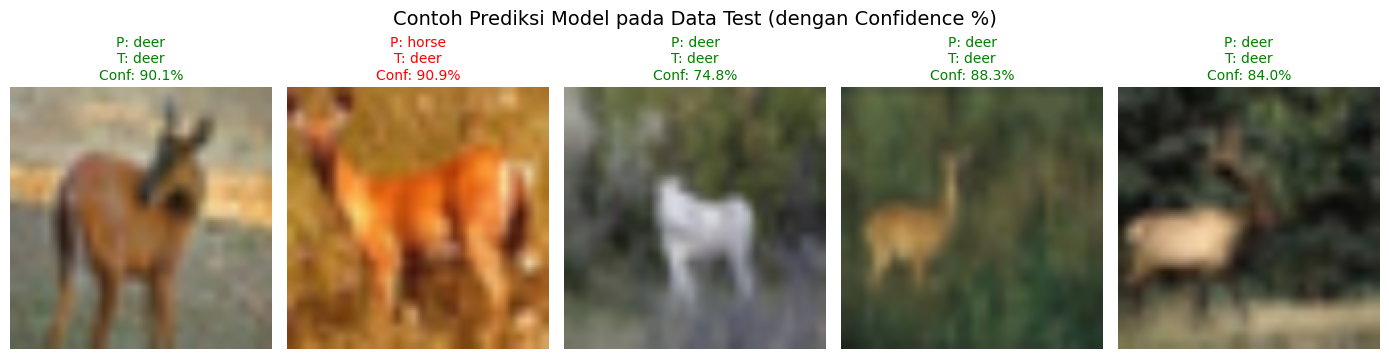

In [19]:
for x_batch, y_batch in test_ds.take(1):
    preds = model.predict(x_batch).ravel()
    label_map = {0: 'deer', 1: 'horse'}

    plt.figure(figsize=(14, 4))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        img = x_batch[i].numpy()
        true_label = int(y_batch[i].numpy())
        prob = preds[i]                # probabilitas dari sigmoid
        pred_label = int(prob >= 0.5)  # threshold 0.5
        confidence = prob * 100 if pred_label == 1 else (1 - prob) * 100
        color = 'green' if pred_label == true_label else 'red'

        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"P: {label_map[pred_label]}\n"
            f"T: {label_map[true_label]}\n"
            f"Conf: {confidence:.1f}%",
            color=color,
            fontsize=10
        )

    plt.suptitle("Contoh Prediksi Model pada Data Test (dengan Confidence %)", fontsize=14)
    plt.tight_layout()
    plt.show()


In [24]:
# ============================================================
# IMPORT PACKAGE
# ============================================================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# SETUP PATH DATA
# ============================================================
DATA_DIR = "Dataset/DEMO"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42

# ============================================================
# FUNGSI HITUNG GAMBAR
# ============================================================
def count_images(folder):
    counts = {}
    total = 0
    for cls in os.listdir(folder):
        path = os.path.join(folder, cls)
        if os.path.isdir(path):
            n = len([f for f in os.listdir(path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[cls] = n
            total += n
    return counts, total

train_counts, train_total = count_images(TRAIN_DIR)
test_counts, test_total = count_images(TEST_DIR)

print("=== Jumlah Data ===")
print("Train:", train_counts, "| Total:", train_total)
print("Test :", test_counts, "| Total:", test_total)
print("====================================\n")

# ============================================================
# DATA AUGMENTATION
# ============================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
], name="data_augmentation")

# ============================================================
# LOAD DATASET
# ============================================================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ============================================================
# NORMALIZATION + PREFETCH
# ============================================================
normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# ============================================================
# MODEL CNN + AUGMENTASI + FINE TUNING
# ============================================================
model = models.Sequential([
    data_augmentation,   # <= augmentasi langsung masuk model
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=IMG_SIZE + (3,)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.30),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.40),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),   # Fine-tuning: naikkan neuron 128 → 256
    layers.Dropout(0.55),                   # Fine-tuning: tingkatkan dropout
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Fine-tuning: lr lebih kecil
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ============================================================
# TRAINING
# ============================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


=== Jumlah Data ===
Train: {'deer': 500, 'horse': 500} | Total: 1000
Test : {'deer': 250, 'horse': 250} | Total: 500

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Found 500 files belonging to 2 classes.


d:\UMM\KULIAH\KULIAH smstr 7\Pembelajaran Mesin\Praktikum\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.5312 - loss: 0.8782 - val_accuracy: 0.4950 - val_loss: 0.6920
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.5038 - loss: 0.6916 - val_accuracy: 0.4950 - val_loss: 0.6913
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.5075 - loss: 0.6878 - val_accuracy: 0.5300 - val_loss: 0.6868
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.5612 - loss: 0.6826 - val_accuracy: 0.6150 - val_loss: 0.6794
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - accuracy: 0.6012 - loss: 0.6657 - val_accuracy: 0.6350 - val_loss: 0.6722
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.6288 - loss: 0.6502 - val_accuracy: 0.7050 - val_loss: 0.6553
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.6425 - loss: 0.6428 - val_accuracy: 0.6700 - val_loss: 0.6521
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.6675 - loss: 0.6210 - val_accuracy

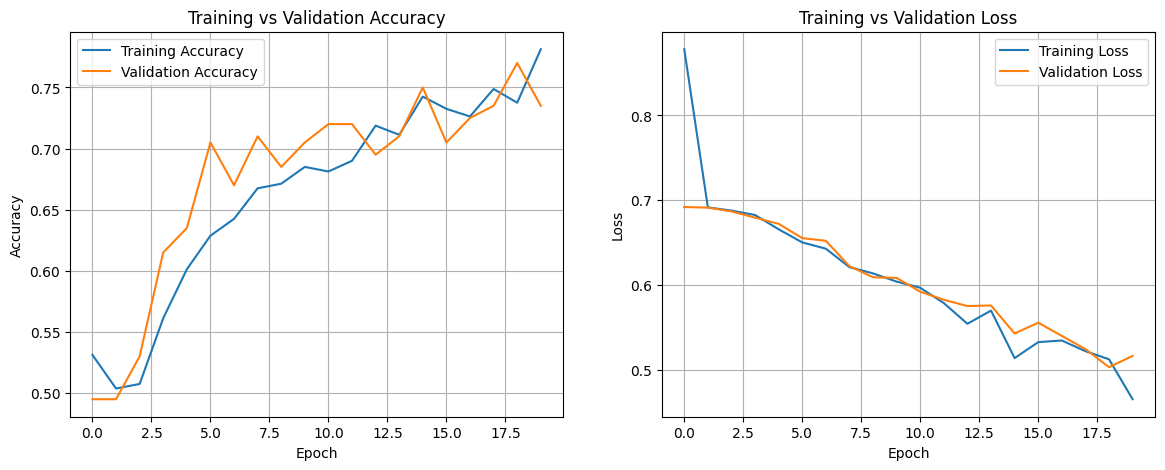

In [25]:
# ============================================================
# GRAFIK TRAINING vs VALIDATION
# ============================================================

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [27]:
# ============================================================
# TABEL LOG FINE-TUNING OTOMATIS (SUPPORT df.head(), df.info())
# ============================================================

import pandas as pd
import tensorflow as tf

def generate_log_table(history, model):
    # Ambil hasil epoch terakhir
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Konfigurasi model
    config = {
        "Augmentasi": "Flip, Rotation, Zoom, Contrast",
        "Dense Neuron": [layer.units for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)],
        "Dropout Rate": [layer.rate for layer in model.layers if isinstance(layer, tf.keras.layers.Dropout)],
        "Learning Rate": float(model.optimizer.learning_rate.numpy()),
        "Conv Layers": sum(isinstance(layer, tf.keras.layers.Conv2D) for layer in model.layers)
    }

    # Buat tabel DataFrame
    df = pd.DataFrame([
        ["Data Augmentation", config["Augmentasi"], 
         f"{final_train_acc:.2f} / {final_train_loss:.2f}", 
         f"{final_val_acc:.2f} / {final_val_loss:.2f}",
         "Peningkatan generalisasi", "Lanjut fine-tuning lain"],

        ["Dense Neuron", str(config["Dense Neuron"]), 
         f"{final_train_acc:.2f}", f"{final_val_acc:.2f}",
         "Jumlah neuron mempengaruhi kapasitas model", "Coba tambah neuron"],

        ["Dropout Rate", str(config["Dropout Rate"]), 
         f"{final_train_acc:.2f}", f"{final_val_acc:.2f}",
         "Regularisasi mengurangi overfitting", "Coba variasi dropout"],

        ["Learning Rate", str(config["Learning Rate"]), 
         f"{final_train_acc:.2f}", f"{final_val_acc:.2f}",
         "LR lebih kecil stabil", "Bisa coba LR scheduler"],

        ["Conv Layers", str(config["Conv Layers"]), 
         f"{final_train_acc:.2f}", f"{final_val_acc:.2f}",
         "Semakin banyak layer, semakin kompleks model", "Pertimbangkan transfer learning"]
    ], columns=["Parameter", "Setting", "Train (Acc/Loss)", "Validation (Acc/Loss)", "Analisis", "Saran"])

    return df


In [29]:
df = generate_log_table(history, model)

df.head()

,Parameter,Setting,Train (Acc/Loss),Validation (Acc/Loss),Analisis,Saran
0,Data Augmentation,"Flip, Rotation, Zoom, Contrast",0.78 / 0.47,0.74 / 0.52,Peningkatan generalisasi,Lanjut fine-tuning lain
1,Dense Neuron,"[256, 1]",0.78,0.74,Jumlah neuron mempengaruhi kapasitas model,Coba tambah neuron
2,Dropout Rate,"[0.25, 0.3, 0.4, 0.55]",0.78,0.74,Regularisasi mengurangi overfitting,Coba variasi dropout
3,Learning Rate,0.0005000000237487257,0.78,0.74,LR lebih kecil stabil,Bisa coba LR scheduler
4,Conv Layers,3,0.78,0.74,"Semakin banyak layer, semakin kompleks model",Pertimbangkan transfer learning


In [34]:
import tensorflow as tf
import numpy as np

IMG_SIZE = (128, 128)   # ukuran harus sama seperti saat training
CLASS_NAMES = ["deer", "Horse"] 

# ======================================================
# Fungsi Prediksi Satu Gambar
# ======================================================
def predict_single_image(model, image_path):
    """
    Melakukan prediksi pada satu gambar.
    Output: label + probabilitas.
    """

    # Load dan preprocess gambar
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0          # normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Prediksi
    pred = model.predict(img_array)[0][0]   # hasil sigmoid 0-1

    # Tentukan label
    if pred >= 0.5:
        label = CLASS_NAMES[1]     # kelas 1
        prob = pred
    else:
        label = CLASS_NAMES[0]     # kelas 0
        prob = 1 - pred

    return label, float(prob)


In [40]:
image_path = "Dataset\d.jpg"      # path gambar kamu
label, prob = predict_single_image(model, image_path)

print("Hasil Prediksi:")
print("Label:", label)
print("Probabilitas:", prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Hasil Prediksi:
Label: deer
Probabilitas: 0.5641825795173645
